In [21]:
from backend.image import Image, Marker, MarkerRectangle2D, MarkerFill2D, MarkerContainer
from backend.filters import  filters_2dim as filters_2d
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from backend import MarkerMakerRectangle2DBinary, Accuracy, Segmentation, Evaluator, MarkerBorder2D
import os
from directory import Directory

In [22]:
PATH_TO_IMG_FOLDER = 'C:/Users/maxxx/VSprojects/back/0/0'
PATH_TO_BORDER_IMG = r'C:\Users\maxxx\VSprojects\back\0\0\border\border00001.png'

FOLDER = Directory(main_path=PATH_TO_IMG_FOLDER)   # Хранилище названий изображений по папкам

# 2D Сегментация

### Загрузка снимка низкого качества, отображение разметки для обучения, выделение границы, которую не нужно учитывать при расчете метрик

instances of class 1 = (606176,)
instances of class 0 = (393824,)


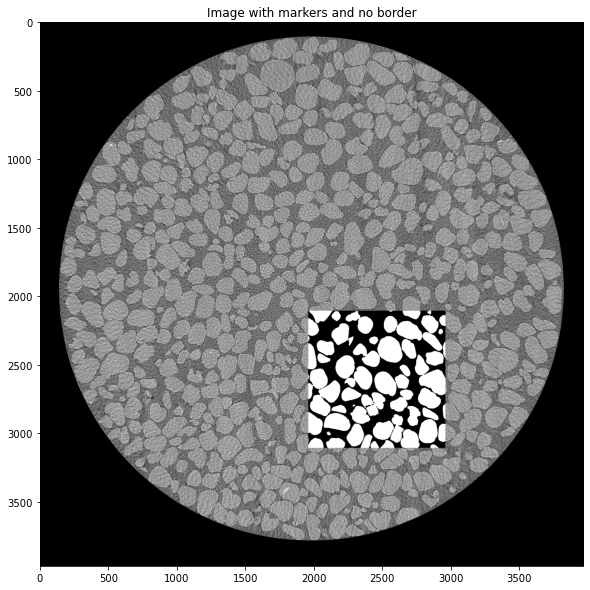

In [23]:
image = Image(path_to_image=FOLDER.ang_dec_folder[0])

point1 = (1957, 2106)
point2 = (1957 + 1000, 2106 + 1000)

markers = MarkerMakerRectangle2DBinary(FOLDER.segmented_folder[0], *point1, *point2).get_markers()
for marker in markers:
    image.draw_marker(marker, color=marker.value * 255)

border_marker = MarkerBorder2D(Image(path_to_image=PATH_TO_BORDER_IMG))
image.draw_marker(border_marker, color=0)
image.show(title="Image with markers and no border") 
image.reset()

### Применение 2д фильтров, сегментация, расчет accuracy

Appplying filters...
Making train data...
Fitting model...
x_train shape = (1000000, 4), y_train shape = (1000000,)
Making predictions...


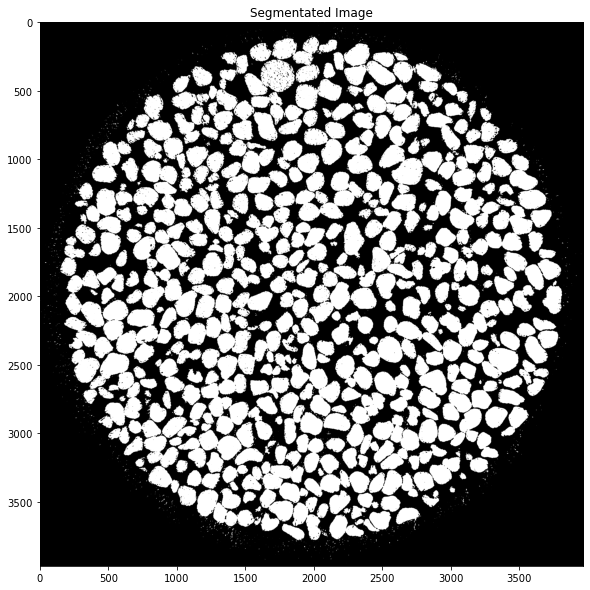

{'Accuracy': 0.9636443045731675}

In [25]:
filters =[filters_2d.MedianFilter(size=5), filters_2d.GaussianFilter(15), filters_2d.LaplacianDifference(),
                              filters_2d.BaseFilter2D()]

# filters = [filters_2d.BaseFilter2D()]  # use img pixels

sgm = Segmentation(model=LogisticRegression(), filters=filters)
result = sgm.fit_and_predict(image, markers)
result.show(title='Segmentated Image')

ground_truth = Image(path_to_image=FOLDER.segmented_folder[0], dim=2)
Evaluator.evaluate(result, ground_truth, markers, border_marker, Accuracy)

### Применение обученной модели на 100 2д срезов исходного 3д снимка

In [26]:
from tqdm.notebook import tqdm
from backend import Image3D
sgm.informing = False

In [32]:
img_3d           = Image3D(img_pathes = FOLDER.ang_dec_folder)
img_3d_segmented = Image3D(img_pathes = FOLDER.segmented_folder)

print(f'3D Image shape = {img_3d.shape}')

sum_acc = 0
n = 0

for img_indx in tqdm(range(len(img_3d))):
    if img_indx != 0:
        img_2d_slice = img_3d[img_indx]
        ground_truth = img_3d_segmented[img_indx]
        
        result = sgm.predict(image = img_2d_slice)
        acc = Evaluator.evaluate(result, ground_truth, [], border_marker, Accuracy)[Accuracy.name]
        
        print(f'Accuracy at step {img_indx} = {acc}')
        sum_acc += acc
        n += 1
    
print(f'Mean accuracy = {sum_acc / n} per {n} images')

3D Image shape = (100, 3968, 3968)


  0%|          | 0/100 [00:00<?, ?it/s]

Accuracy at step 1 = 0.964536267748097
Accuracy at step 2 = 0.9646857798812559
Accuracy at step 3 = 0.9647480687624084
Accuracy at step 4 = 0.9650010820576032
Accuracy at step 5 = 0.9650882112176441
Accuracy at step 6 = 0.9650581017886882
Accuracy at step 7 = 0.9650956444829176
Accuracy at step 8 = 0.9652480734670067
Accuracy at step 9 = 0.9655040036131315
Accuracy at step 10 = 0.9656265113521957
Accuracy at step 11 = 0.9655256447651935
Accuracy at step 12 = 0.9653238174992237
Accuracy at step 13 = 0.9652259618551172
Accuracy at step 14 = 0.9653637124925902
Accuracy at step 15 = 0.965482080185173
Accuracy at step 16 = 0.9656856011065215
Accuracy at step 17 = 0.9659751220843252
Accuracy at step 18 = 0.9660516188522662
Accuracy at step 19 = 0.9659996800873173
Accuracy at step 20 = 0.965991117718458
Accuracy at step 21 = 0.965973522520912
Accuracy at step 22 = 0.9657167455470977
Accuracy at step 23 = 0.9657551350690164
Accuracy at step 24 = 0.9656941634753808
Accuracy at step 25 = 0.96571

In [33]:
print(f'Mean accuracy = {round(sum_acc / n, 3)} per {n} images')

Mean accuracy = 0.966 per 99 images


# 3D Сегментация

In [34]:
from backend import MarkerMaker3DBinary, Segmentation3D, Image3D

In [37]:
img_3d           = Image3D(img_pathes = FOLDER.ang_dec_folder)
img_3d_segmented = Image3D(img_pathes = FOLDER.segmented_folder)


point1 = (1957,       2106,       0)
point2 = (1957 + 100, 2106 + 500, 0 + 4)


markers = MarkerMaker3DBinary(*point1, *point2).get_markers(img_3d_segmented)
filters = [filters_2d.BaseFilter2D(), filters_2d.BaseFilter2D()]

sgm_3d = Segmentation3D(LogisticRegression(),
                            [filters_2d.BaseFilter2D(), filters_2d.BaseFilter2D()],
                            batch_size=10, informing=True)

sgm_3d.fit(img_3d, markers)

DEPTH_TO_PREDICT = 20

img_3d.clear_cache()
img_3d.load_images(0, DEPTH_TO_PREDICT - 1)
preds = sgm_3d.predict(img_3d)
img_3d.clear_cache()


print(f'\npredictions shape = {preds.shape}')

instances of class 1 = (133097,)
instances of class 0 = (66903,)
Appplying filters...
Making train data...
Fitting model...
Appplying filters...
Making predictions...

predictions shape = (20, 3968, 3968)


### гифка с сегментированными снимками

In [35]:
import matplotlib.animation as animation
from matplotlib import pyplot as plt
from IPython.display import Image
import numpy as np


def make_animation(data: np.ndarray, h_step = 1, w_step = 1, file_name: str = None):
    if file_name is None or '.' not in file_name:
        file_name = 'test.gif'
            
    GIF_FPS = 8
    fig = plt.figure(figsize=(16, 12))
    all_frames = len(data)
    
    def animate(i: int):
        plt.title(f'depth = {i}')
        plt.imshow(data[i, ::w_step, ::h_step], cmap='gray')
        print(f'frame {i} / {all_frames}', end='\r')
    
    
    result = animation.FuncAnimation(fig, animate, frames=all_frames)
    result.save(file_name, writer='pillow', fps=GIF_FPS)
    plt.close()
    
    return file_name

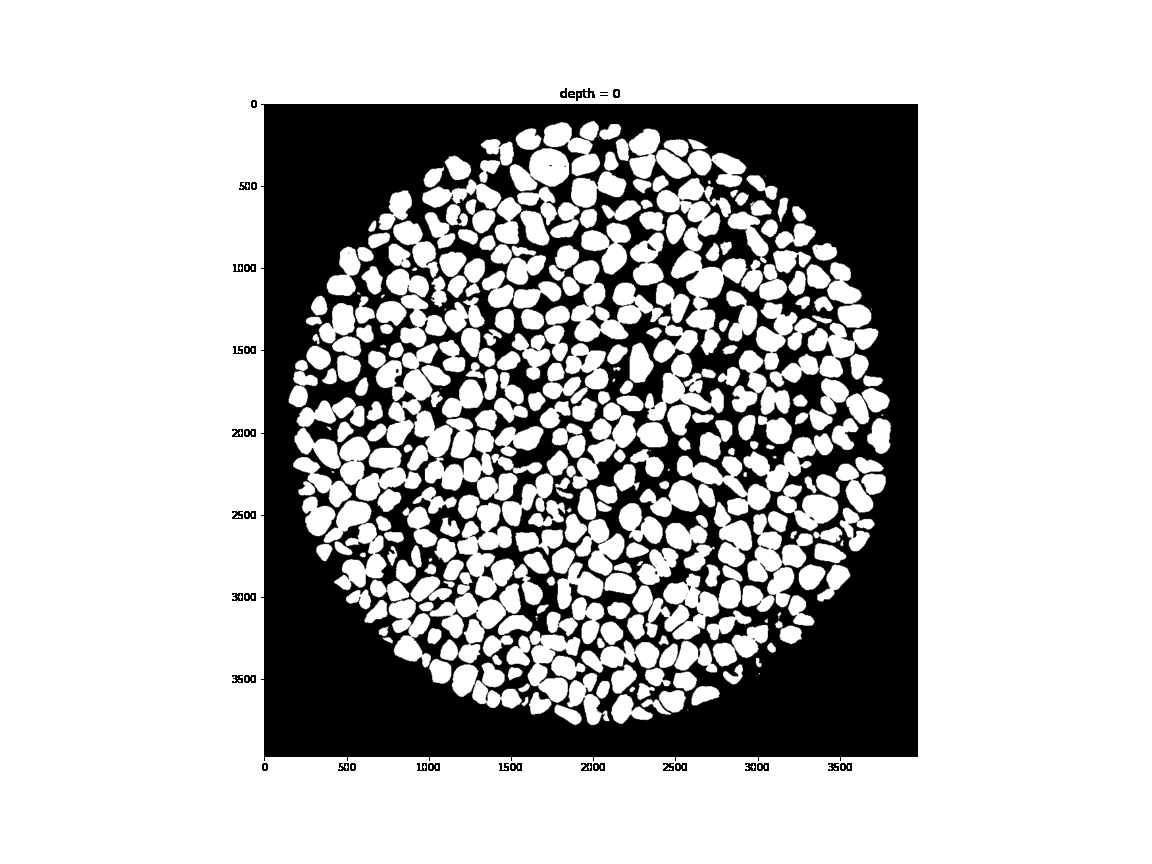

In [36]:
file_name = make_animation(preds)
Image(open(file_name,'rb').read())

In [38]:
#расчет accuracy для 3D изображания, глубиной в 10 снимков

EXTRA_VALUE = 999
mask = np.copy(preds)
for marker in markers:
    x_indexes, y_indexes, z_indexes = marker.get_indexes()
    mask[z_indexes, y_indexes, x_indexes] = EXTRA_VALUE

x_indexes, y_indexes = border_marker.get_indexes()
mask[:, y_indexes, x_indexes] = EXTRA_VALUE

z_index_test, y_index_test, x_index_test  = np.where(mask != EXTRA_VALUE)


img_3d_segmented.load_images(0, DEPTH_TO_PREDICT - 1)

y_real = np.copy(img_3d_segmented.data[z_index_test, y_index_test, x_index_test])
y_pred = mask[z_index_test, y_index_test, x_index_test]

if np.max(y_pred) == 1:
    y_pred *= 255
Accuracy.get_score(y_pred=y_pred, y_real=y_real)

0.850593893331073